In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
nd = 2  # dimensions of space we're working in

n = 16  # number of points, also batch size

random_points = False 
torch.random.manual_seed(0)
if random_points:
    vecs = 0.5* torch.randn((n, nd))
else:   
    # start all in a line going from 1 to -1
    vecs = torch.zeros((n, nd))
    vecs[:,0] = torch.linspace(1.0, -1.0, n)


# supervised learning targets
thetas = 6.28/n*torch.arange(n).unsqueeze(0)
targets = torch.cat((torch.cos(thetas), torch.sin(thetas))).T


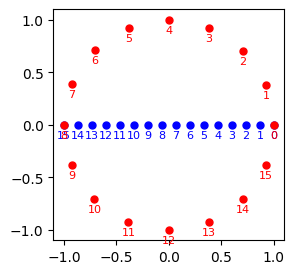

In [4]:
def plot_w_labels(ax, v, c='b', with_nums=True, ha='center', va='top', label='', markersize=5): 
    x, y = v[:,0].numpy(), v[:,1].numpy()
    ax.plot(x,y,'o', c=c,label=label, markersize=markersize)
    if with_nums:
        for i, (xi, yi) in enumerate(zip(x, y)):
            ax.text(xi, yi-0.05, str(i), ha=ha, va=va, c=c, fontsize=8)
        
def plot_graph(vecs, targets=None, v_hats=None, v_hats_t=None, legend=False, with_nums=True):
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(3,3))
        plot_w_labels(ax, vecs.cpu(), label='v', with_nums=with_nums)
        if targets is not None: plot_w_labels(ax, targets, c='r', label='targ', with_nums=with_nums)
        if v_hats is not None: plot_w_labels(ax, v_hats,  c='g', label='v_hat', with_nums=with_nums) 
        if v_hats_t is not None: plot_w_labels(ax, v_hats_t,  c='violet', ha='left',va='bottom', label='v_hat_t', with_nums=with_nums)
        ax.set_aspect('equal')
        if legend: ax.legend()                           
        return plt.show()

plot_graph(vecs,targets, with_nums=True)

In [5]:
class Projector(nn.Module):
    " some kind of learned nonlinear transformation into some new space"
    def __init__(self, 
                 nd=2,   # number of dims of the space
                 n_hid=32, # number of hidden dims of the network
                 ):
        super().__init__()
        self.fc1 = nn.Linear(nd, n_hid, bias=True)
        self.fc2 = nn.Linear(n_hid, n_hid, bias=True)
        self.fc3 = nn.Linear(n_hid, nd, bias=True)
        self.bn1 = nn.BatchNorm1d(n_hid)
        self.bn2 = nn.BatchNorm1d(n_hid)
        self.bn3 = nn.BatchNorm1d(n_hid)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.act ( self.fc1(x) )
        x = self.bn1(x)
        x = self.act ( self.fc2(x) )
        x = self.bn2(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        #x = torch.tanh(x)
        return x 

proj = Projector(nd=nd).to(device)
optimizer = Adam(proj.parameters(), lr=0.02)

/home/shawley/envs/oplas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I. Supervised Learning
We just minimize the difference between the outputs and the targets. Easy. 

In [6]:
max_steps = 1024
n_frames = 10

print_every = max_steps//n_frames # 100
last_printed, print_interval, print_gamma = -1, 1, 1.5

outs_list = []
for step in range(max_steps):
    t = step 
    optimizer.zero_grad()
    v_hats = proj(vecs.to(device))
    loss = F.mse_loss(v_hats, targets.to(device))
    #print("step, last_printed, print_interval, print_gamma = ",step, last_printed, print_interval, print_gamma)
    
    if step == int(last_printed + print_interval):
        print(f"step {step}/{max_steps}: loss = ",loss.item())
        #plot_graph(vecs,targets, v_hats=v_hats)
        outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':targets.detach().cpu(), 'v_hats':v_hats.detach().cpu()}
        outs_list.append(outs)
        print_interval = print_interval * print_gamma
        last_printed = step
    loss.backward()
    optimizer.step()

step 0/1024: loss =  1.0268831253051758
step 1/1024: loss =  0.8103584051132202
step 3/1024: loss =  0.09744355082511902
step 6/1024: loss =  0.08019250631332397
step 11/1024: loss =  0.042976099997758865
step 18/1024: loss =  0.019467055797576904
step 29/1024: loss =  0.006854379083961248
step 46/1024: loss =  0.0017499300884082913
step 71/1024: loss =  0.00022058089962229133
step 109/1024: loss =  7.448219548678026e-05
step 166/1024: loss =  2.879958992707543e-05
step 252/1024: loss =  7.993634426384233e-06
step 381/1024: loss =  3.235732037865091e-06
step 575/1024: loss =  1.8050375274469843e-06
step 866/1024: loss =  9.938389666785952e-07


Plot a suggession of frames

In [82]:
def plot_frames(outs_list, legend=False, ncols=5, with_nums=True):
    n_frames = len(outs_list)
    print("n_frames = ",n_frames)
    nrows = int(round(n_frames/ncols))
    fig_width = 1.4 * ncols
    fig_height = 1.4 * nrows
    fig, axs = plt.subplots(figsize=(fig_width, fig_height), nrows=nrows, 
                            ncols=ncols, sharey=True, sharex=True, 
                            gridspec_kw={'hspace': 0})
    # Manually set positions and remove spacing
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])
        #ax.set_aspect('equal') 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    for i, outs in enumerate(outs_list):
        if i >= len(axs.flatten()): break
        ax = axs.flatten()[i]
        #ax.text(-1.1,0.94,f"S-{outs['step']}", fontsize=9)
        ax.text(0.01, .92, f"S-{outs['step']}", fontsize=9, transform=ax.transAxes)
        plot_w_labels(ax, outs['vecs'], label='v', with_nums=with_nums)
        if 'targets'  in outs.keys(): plot_w_labels(ax, outs['targets'],  c='r', label='targ', with_nums=with_nums)
        if 'v_hats'   in outs.keys(): plot_w_labels(ax, outs['v_hats'],   c='g', label='v_hat', with_nums=with_nums) 
        if 'v_hats_t' in outs.keys(): plot_w_labels(ax, outs['v_hats_t'], c='violet', ha='left',va='bottom', label='v_hat_t', with_nums=with_nums)
        ax.set_aspect('equal')
        if legend: ax.legend() 
    plt.show()
    return fig 

In [78]:
fig = plot_frames(outs_list, with_nums=True)

n_frames =  0


ValueError: Number of rows must be a positive integer, not 0

<Figure size 700x0 with 0 Axes>

# II. Contrastive Loss
Here we simply enforce that some "operation" holds. For example, that the transform of each point is very close to the transform of the next point. 

## IIa. Explicit affine + rotation operator

In [9]:
def get_rot(theta, nd=2):
    c, s = torch.cos(theta), torch.sin(theta)
    return torch.tensor([ [c, -s],[s,c] ])

class FiLMR2d(nn.Module):
    "affine transformation plus rotation, in 2d"
    def __init__(self, nd=2, 
                 beta_init_fac = 0.0001, # tiny beta is maybe cheating
                 theta_init_fac=6.28/n, # 2pi/n init is "cheating" a bit
                 ):
        super().__init__()
        self.gamma =  nn.Parameter(torch.ones((1)))
        self.beta =  beta_init_fac*nn.Parameter(torch.randn((1)))
        self.theta = theta_init_fac*nn.Parameter( torch.ones((1)) ) 

    def forward(self, x):
        rot = get_rot(self.theta).to(x.device)
        return (x * self.gamma + self.beta.to(x.device)) @ rot

In [27]:
# and set up for that      

proj2 = Projector(nd=nd).to(device)
trans_op = FiLMR2d(nd=nd).to(device)

lr = 1e-3
optimizer = AdamW( list(proj2.parameters())+list(trans_op.parameters()), lr=lr)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000, T_mult=2)

max_steps = 2**17+1

#scheduler = lr_scheduler.OneCycleLR(optimizer, 2e-3, total_steps=max_steps)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=max_steps)

margin = 6/n # spacing beyond which not to push
criterion = torch.nn.TripletMarginLoss(margin=margin)
#distance_func = lambda x,y: ( ((x-y)**2).sum(-1) ) # don't take square root.
#criterion = torch.nn.TripletMarginWithDistanceLoss(distance_function=distance_func, margin=margin)

Now train...

print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 24576, 32768, 40960, 49152, 57344, 65536, 73728, 81920, 90112, 98304, 106496, 114688, 122880, 131072, 139264, 147456, 155648, 163840, 172032, 180224, 188416, 196608, 204800, 212992, 221184, 229376, 237568, 245760, 253952]
Step 1/131073: lr = 1.0000e-03, loss = 5.3967e-01


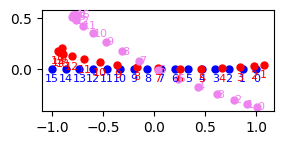

Step 2/131073: lr = 1.0000e-03, loss = 4.6643e-01


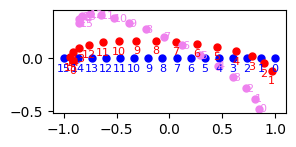

Step 4/131073: lr = 1.0000e-03, loss = 3.1135e-01


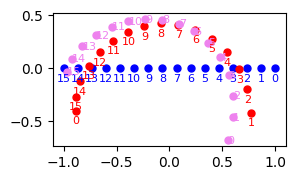

Step 8/131073: lr = 1.0000e-03, loss = 2.7207e-01


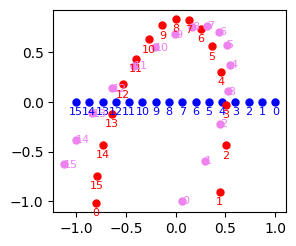

Step 16/131073: lr = 1.0000e-03, loss = 1.2971e-01


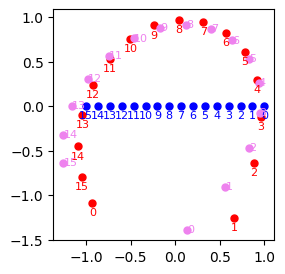

Step 32/131073: lr = 1.0000e-03, loss = 1.3081e-03


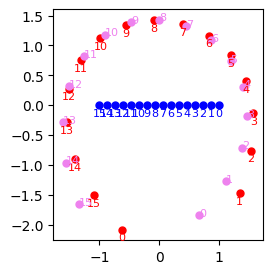

Step 64/131073: lr = 1.0000e-03, loss = 1.3456e-03


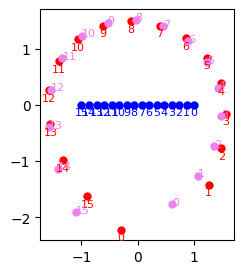

Step 128/131073: lr = 1.0000e-03, loss = 1.1530e-03


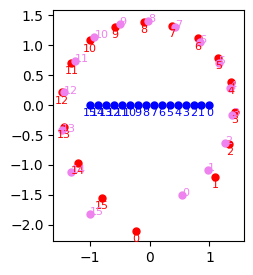

Step 256/131073: lr = 9.9999e-04, loss = 1.0137e-03


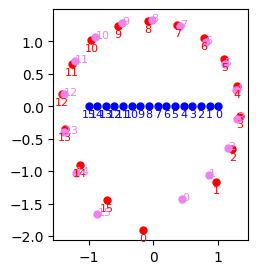

Step 512/131073: lr = 9.9996e-04, loss = 9.4587e-04


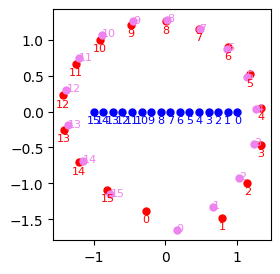

Step 1024/131073: lr = 9.9985e-04, loss = 7.3722e-04


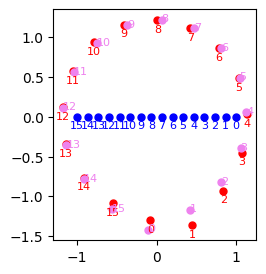

Step 2048/131073: lr = 9.9940e-04, loss = 1.0288e-03


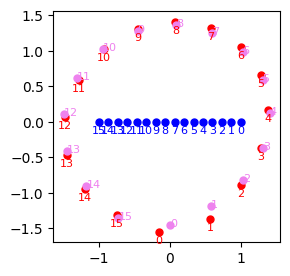

Step 4096/131073: lr = 9.9759e-04, loss = 8.8734e-04


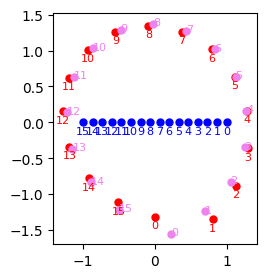

Step 8192/131073: lr = 9.9039e-04, loss = 1.0465e-03


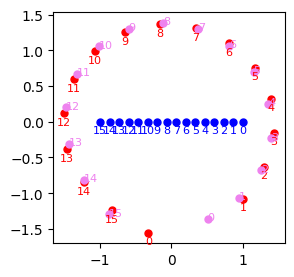

Step 16384/131073: lr = 9.6194e-04, loss = 7.8533e-04


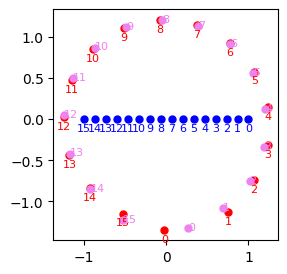

Step 24576/131073: lr = 9.1574e-04, loss = 6.3303e-04


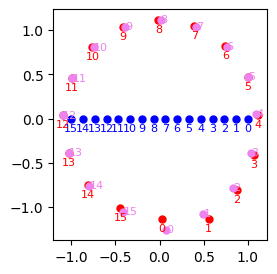

Step 32768/131073: lr = 8.5356e-04, loss = 9.1935e-04


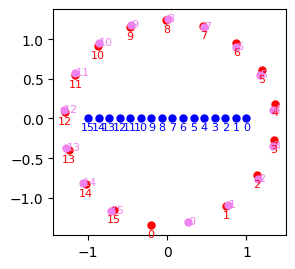

Step 40960/131073: lr = 7.7779e-04, loss = 2.4491e-03


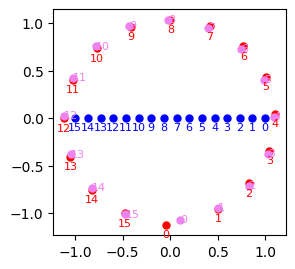

Step 49152/131073: lr = 6.9135e-04, loss = 6.5603e-04


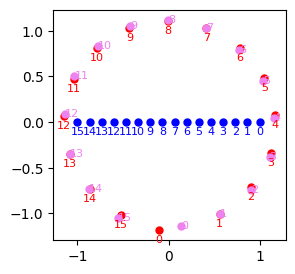

Step 57344/131073: lr = 5.9755e-04, loss = 5.8356e-04


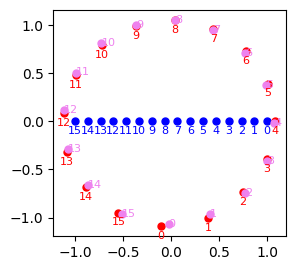

Step 65536/131073: lr = 5.0001e-04, loss = 5.7149e-04


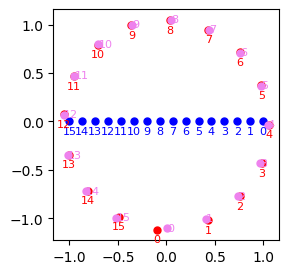

Step 73728/131073: lr = 4.0246e-04, loss = 5.4575e-04


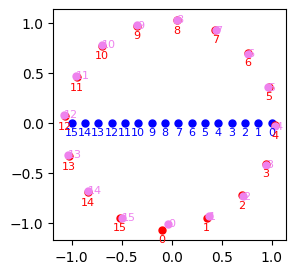

Step 81920/131073: lr = 3.0867e-04, loss = 5.4332e-04


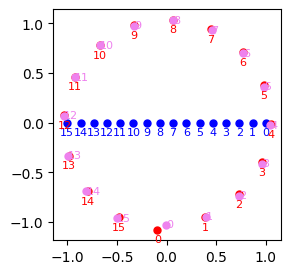

Step 90112/131073: lr = 2.2222e-04, loss = 5.0297e-04


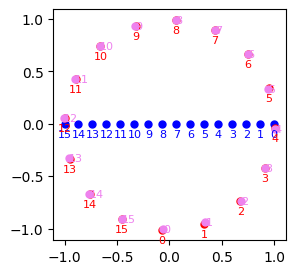

Step 98304/131073: lr = 1.4645e-04, loss = 4.9422e-04


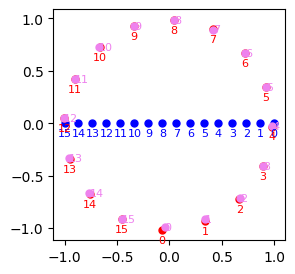

Step 106496/131073: lr = 8.4271e-05, loss = 4.8338e-04


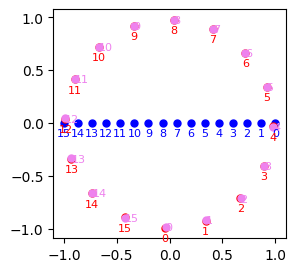

Step 114688/131073: lr = 3.8064e-05, loss = 4.7630e-04


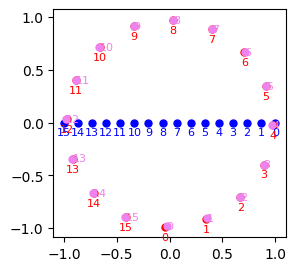

Step 122880/131073: lr = 9.6096e-06, loss = 4.6685e-04


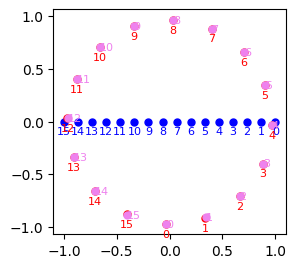

Step 131072/131073: lr = 1.4362e-13, loss = 4.6572e-04


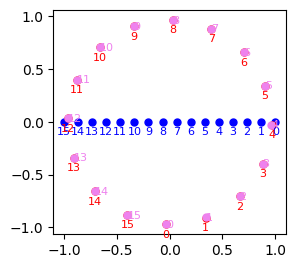

In [28]:
outs_list = []
losses, lrs = [], []
outs2_list = []
print_at = [2**n for n in range(14)]
print_at = print_at+ [print_at[-1]*(x+2) for x in range(30)]
#print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 12000, 16384, 24000, 32768]
print("print_at = ",print_at)
for step in range(max_steps):
    optimizer.zero_grad()
    vecs = vecs.to(device)
    v_hat = proj2(vecs)            # move to a 'circle'
    rolled = torch.roll(v_hat, 1, 0) # location of next one on 'circle'

    v_hat_t = trans_op(v_hat) # transform from one location on circle to new location on 'circle'
    
    #proj_loss =  F.mse_loss(v_hat_t, rolled)  # minimize transformed and next one (contractive)
    #marg_loss =  F.relu( margin - (v_hat - rolled)**2 ).mean()    # keep a minimum distance from the next one though (repulsive)
 
    mag_loss = (v_hat**2 + v_hat_t**2 + rolled**2).mean()/3  # keep things from getting too far out there
    #mag_loss = -1.5+((0.5/v_hat**2 + v_hat) + (0.5/v_hat_t**2 + v_hat_t) + (0.5/rolled**2 + rolled)).mean()/3  # "celestial loss"
    #mag_loss = mag_loss -1 + 0.1 + (1.0/(v_hat**2+0.1) + 1.0/(v_hat_t**2+0.1) + 1.0/(rolled**2+0.1)).mean()/3  # swinging spring loss

    anchor, pos, neg = rolled, v_hat_t, v_hat
    #anchor, pos, neg = v_hat_t, rolled, v_hat

    loss = criterion(anchor, pos, neg) + 0.001*mag_loss
    
    losses.append(loss.item())
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    
    #if step % print_every == 0:
    if step in print_at:
        with torch.no_grad():
            print(f"Step {step}/{max_steps}: lr = {lr:.4e}, loss = {loss.item():.4e}")
            #print(f"v_hat[0:1] = {v_hat[0:2,:].numpy()}, v_hat_t[0]={v_hat_t[0].numpy()}")
            plot_graph(vecs.cpu(), targets=rolled.cpu(), v_hats=None, v_hats_t=v_hat_t.cpu(), with_nums=True)
            outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':rolled.detach().cpu(), 'v_hats_t':v_hat_t.detach().cpu()}
            outs2_list.append(outs)
        
    loss.backward(retain_graph=True) 
    optimizer.step()
    scheduler.step()


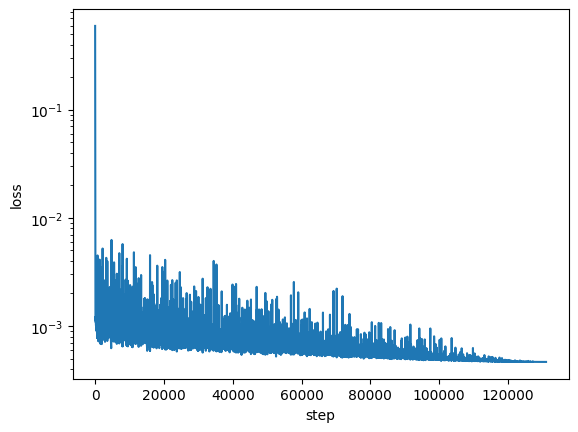

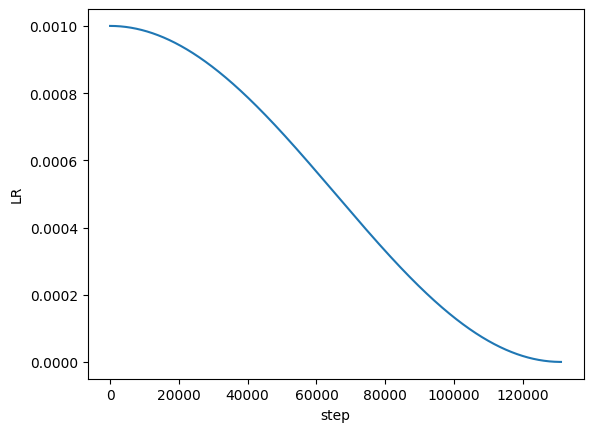

In [29]:
def plot_losses_and_lrs(losses,lrs):
    plt.semilogy(losses)
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.show()

    plt.plot(lrs)
    plt.ylabel('LR')
    plt.xlabel('step')
    plt.show()

plot_losses_and_lrs(losses,lrs)

n_frames =  10


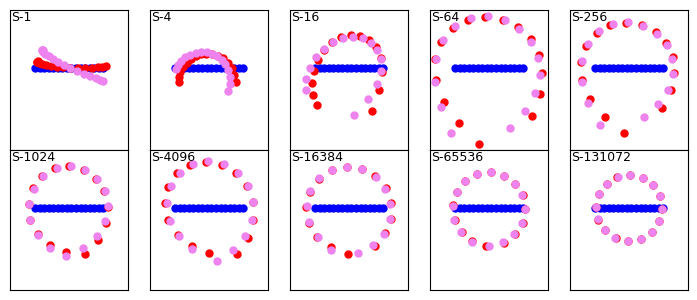

In [110]:
inds = [0,2,4,6,8,10,12,14,20,28]
outs3_list = [outs2_list[i] for i in inds]
fig = plot_frames(outs3_list, ncols=5, with_nums=False)

In [ ]:
fig.savefig('FiLMR2d.png')

## IIb. "Just learn a square (/ orthogonal) matrix"
...doesn't seem to learn

max_steps =  131073
print_at =  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608]
Step 1/131073: lr = 4.000e-05, loss = 1.003e+00


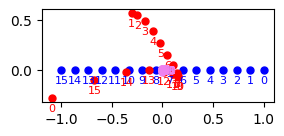

Step 2/131073: lr = 4.000e-05, loss = 1.001e+00


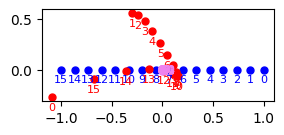

Step 4/131073: lr = 4.000e-05, loss = 9.968e-01


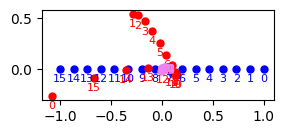

Step 8/131073: lr = 4.000e-05, loss = 9.888e-01


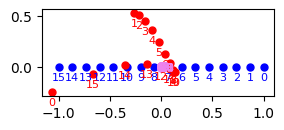

Step 16/131073: lr = 4.000e-05, loss = 9.742e-01


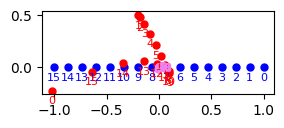

Step 32/131073: lr = 4.000e-05, loss = 9.439e-01


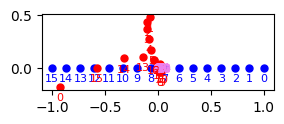

Step 64/131073: lr = 4.001e-05, loss = 9.220e-01


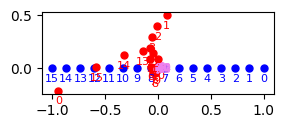

Step 128/131073: lr = 4.003e-05, loss = 8.980e-01


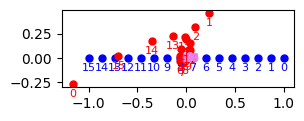

Step 256/131073: lr = 4.010e-05, loss = 8.716e-01


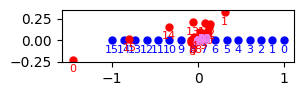

Step 512/131073: lr = 4.040e-05, loss = 8.315e-01


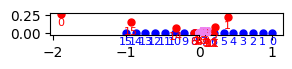

Step 1024/131073: lr = 4.161e-05, loss = 8.154e-01


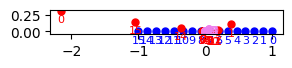

Step 2048/131073: lr = 4.641e-05, loss = 7.793e-01


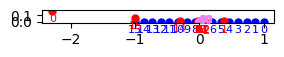

Step 4096/131073: lr = 6.547e-05, loss = 7.585e-01


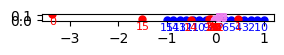

Step 8192/131073: lr = 1.392e-04, loss = 7.453e-01


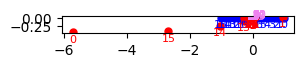

Step 16384/131073: lr = 3.958e-04, loss = 6.473e-01


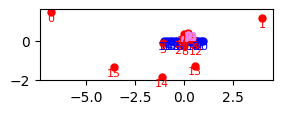

Step 32768/131073: lr = 9.357e-04, loss = 4.894e-01


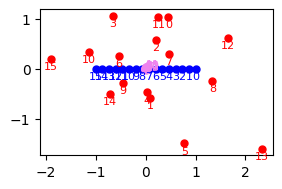

Step 65536/131073: lr = 8.117e-04, loss = 4.869e-01


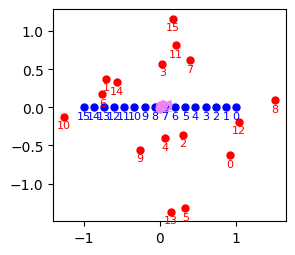

Step 131072/131073: lr = 4.000e-09, loss = 4.851e-01


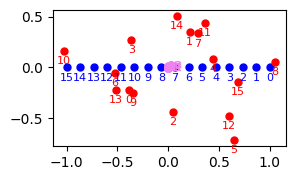

In [111]:
class MatOp(nn.Module):
    " just a square matrix operation"
    def __init__(self, nd=2):
        super().__init__()
        self.mat = 0.1*nn.Parameter(torch.randn((nd,nd)))
        #self.mat = nn.Embedding(nd,nd)
        
    def forward(self, x):
        #print("HI!!  self.mat.shape, x.shape = ",self.mat.shape, x.shape)
        x = self.mat.to(x.device).T @ x.T
        x = x.T @ self.mat.to(x.device)
        #return x @ self.mat.weight
        return x
        

proj3 = Projector(nd=nd).to(device)
trans_op2 = MatOp(nd=nd).to(device)

optimizer = AdamW( list(proj3.parameters())+list(trans_op2.parameters()), lr=5e-4)
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1000, T_mult=2)

#max_steps = 40000
print("max_steps = ",max_steps)
scheduler = lr_scheduler.OneCycleLR(optimizer, 1e-3, total_steps=max_steps)

margin = 6/n
criterion = torch.nn.TripletMarginLoss(margin)


print_every = max_steps/20
print_at = [2**n for n in range(24)]
print("print_at = ",print_at)

losses, lrs = [], []
outs3_list = []
for step in range(max_steps):
    optimizer.zero_grad()
    v_hat = proj3(vecs.to(device))            # move to a 'circle'
    rolled = torch.roll(v_hat, 1, 0) # location of next one on 'circle'

    v_hat_t = trans_op2(v_hat) # transform from one location on circle to new location on 'circle'
    
    mag_loss = (v_hat**2 + v_hat_t**2 + rolled**2).mean()/3.0  # keep things from getting too far out there
    ortho_loss = F.mse_loss(trans_op2.mat.T @ trans_op2.mat, torch.eye(trans_op2.mat.shape[-1]))

    anchor, pos, neg = rolled, v_hat_t, v_hat
    loss = criterion(anchor, pos, neg) + 0.01*mag_loss + ortho_loss
    
    losses.append(loss.item())
    lr = optimizer.param_groups[0]['lr']
    lrs.append(lr)
    
    #if (step+1) % print_every == 0:
    if step in print_at:
        with torch.no_grad():
            print(f"Step {step}/{max_steps}: lr = {lr:.3e}, loss = {loss.item():.3e}")
            plot_graph(vecs.cpu(), targets=rolled.cpu(), v_hats=None, v_hats_t=v_hat_t.cpu(), with_nums=True)
            outs = {'step':step, 'loss':loss.item(), 'vecs':vecs.detach().cpu(), 'targets':rolled.detach().cpu(), 'v_hats_t':v_hat_t.detach().cpu()}
            outs3_list.append(outs)
        
    loss.backward(retain_graph=True) 
    optimizer.step()
    scheduler.step()

Tends to get long & skinny and stay that way. 

TODO: add loss that penalizes linear shapes.  e.g. subtract area of convex hull

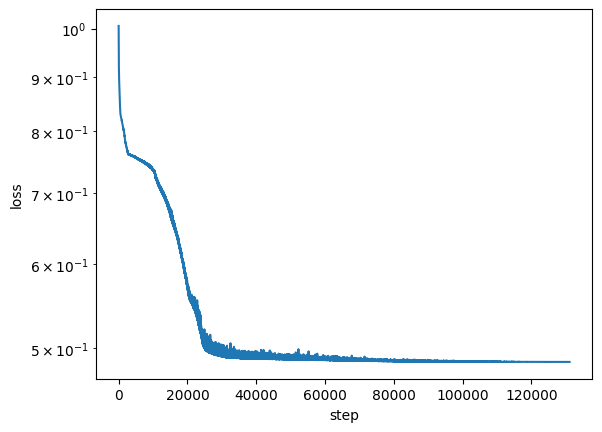

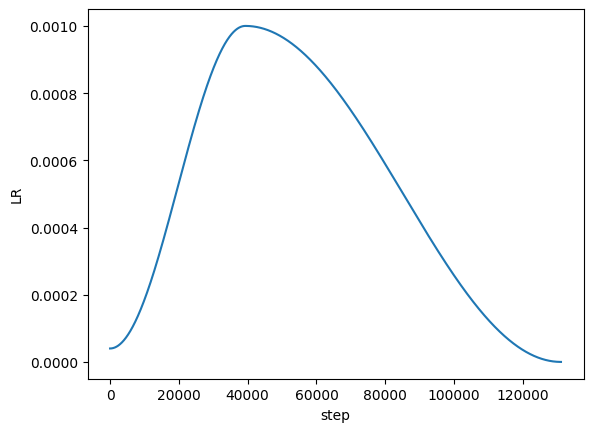

In [112]:
plot_losses_and_lrs(losses,lrs)

n_frames =  10


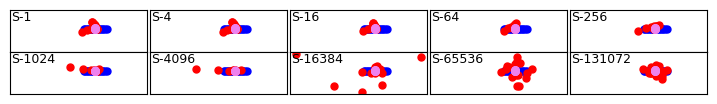

In [127]:
def plot_frames2(outs_list, legend=False, ncols=5, with_nums=True):
    n_frames = len(outs_list)
    print("n_frames = ",n_frames)
    nrows = int(round(n_frames/ncols))
    fig_width = 1.4 * ncols
    fig_height = 1.4 * nrows *.3
    fig, axs = plt.subplots(figsize=(fig_width, fig_height), nrows=nrows, 
                            ncols=ncols, sharey=True, sharex=True, 
                            gridspec_kw={'hspace': 0})
    # Manually set positions and remove spacing
    for ax in axs.flat:
        ax.set(xticks=[], yticks=[])
        #ax.set_aspect('equal') 
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    for i, outs in enumerate(outs_list):
        if i >= len(axs.flatten()): break
        ax = axs.flatten()[i]
        #ax.text(-1.1,0.94,f"S-{outs['step']}", fontsize=9)
        ax.text(0.01, .73, f"S-{outs['step']}", fontsize=9, transform=ax.transAxes)
        plot_w_labels(ax, outs['vecs'], label='v', with_nums=with_nums)
        if 'targets'  in outs.keys(): plot_w_labels(ax, outs['targets'],  c='r', label='targ', with_nums=with_nums)
        if 'v_hats'   in outs.keys(): plot_w_labels(ax, outs['v_hats'],   c='g', label='v_hat', with_nums=with_nums) 
        if 'v_hats_t' in outs.keys(): plot_w_labels(ax, outs['v_hats_t'], c='violet', ha='left',va='bottom', label='v_hat_t', with_nums=with_nums)
        ax.set_aspect('equal')
        if legend: ax.legend() 
    plt.show()
    return fig 


inds = [0,2,4,6,8,10,12,14,16,17]
outs4_list = [outs3_list[i] for i in inds]
fig = plot_frames2(outs4_list, ncols=5, with_nums=False)

In [ ]:
fig.savefig('MatOp.png')

TODO: try VICReg!